In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/jigsaw-toxic-comment-classification-challenge.zip -d data

Archive:  drive/MyDrive/jigsaw-toxic-comment-classification-challenge.zip
  inflating: data/sample_submission.csv.zip  
  inflating: data/test.csv.zip       
  inflating: data/test_labels.csv.zip  
  inflating: data/train.csv.zip      


In [4]:
train_data=pd.read_csv('data/train.csv.zip')

In [5]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [6]:
test_data=pd.read_csv('data/test.csv.zip')

In [7]:
test_data

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [8]:
test_label=pd.read_csv('data/test_labels.csv.zip')
test_label

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1


In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
#https://www.kaggle.com/gtskyler/toxic-comments-bert

In [10]:
train_data['comment_texxt'] = train_data['comment_text'].map(lambda text: clean_text(text))
test_data['comment_texxt'] = test_data['comment_text'].map(lambda text: clean_text(text))

In [11]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_texxt
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d aww he matches this background colour i am s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i am really not trying to edit war it ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i cannot make any real suggestions on imp...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,and for the second time of asking when your vi...
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,you should be ashamed of yourself that is a ho...
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,spitzer umm theres no actual article for prost...
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,and it looks like it was actually you who put ...


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [13]:
train_values_x = train_data['comment_texxt'].values
train_values_y = train_data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values

In [14]:
train_values_x

array(['explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27',
       'd aww he matches this background colour i am seemingly stuck with thanks talk 21 51 january 11 2016 utc',
       'hey man i am really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info',
       ...,
       'spitzer umm theres no actual article for prostitution ring crunch captain',
       'and it looks like it was actually you who put on the speedy to have the first version deleted now that i look at it',
       'and i really do not think you understand i came here and my idea was bad right away what kind of community goes you have bad ideas go away ins

In [15]:
train_values_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [16]:
# Split training, validation set
train_x, val_x, train_y, val_y = train_test_split(train_values_x, train_values_y, test_size=0.2, random_state=30)

In [17]:
train_x

array(['you had the image name right but you left a blank width parameter that apparently prevented the image from showing',
       'aksungur hi nico you have created the article aksungur please see my note in the discussion page talk have a good day',
       'samaleks if you can prove that i am from that douchebag forum called skyscrapercity or that i am a meat puppet please go ahead please be aware that i will continue to revert false propaganda and correct information on pages if you revert my corrected information that turns out to be war so you are the one starting the war',
       ...,
       'national playing fields association just thought you might like to see how with the help of the npfa the page has grown since your initial creation i am sure there is still far more to do',
       're booth swarbrick and whalen sorry i posted that request was so long ago that now i can scarcely remember what i was after once upon a time i think the larkin page made reference to these books 

In [18]:
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(127656,)
(127656, 6)
(31915,)
(31915, 6)


In [19]:
# Tokenize training data
vocab_len = 100000
tokenizer = Tokenizer(num_words = vocab_len, oov_token='<oov>')
tokenizer.fit_on_texts(train_data['comment_texxt'])

In [20]:
# Encode training data sentences into sequences
train_seq = tokenizer.texts_to_sequences(train_x)

In [21]:
# Get our training data word index
word_index = tokenizer.word_index

In [22]:
# Get max training sequence length
maxlen = max([len(x) for x in train_seq])
print(maxlen)

1403


In [23]:
# Pad the training sequences
train_pad = pad_sequences(train_seq, maxlen = maxlen,
                          padding = 'pre',
                          truncating='pre')

In [24]:
# print("\nTraining sequences:\n", train_seq)
# print("\nPadded training sequences:\n", train_pad)
print("\nPadded training shape:", train_pad.shape)
print("Training sequences data type:", type(train_seq))
print("Padded Training sequences data type:", type(train_pad))


Padded training shape: (127656, 1403)
Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [25]:
val_seq = tokenizer.texts_to_sequences(val_x)
val_pad = pad_sequences(val_seq, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')

In [26]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

187003

In [27]:
!wget dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip

--2021-11-21 10:56:39--  http://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  28.7MB/s    in 51s     

2021-11-21 10:57:31 (28.5 MB/s) - ‘crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [28]:
!unzip crawl-300d-2M.vec.zip 

Archive:  crawl-300d-2M.vec.zip
  inflating: crawl-300d-2M.vec       


In [29]:
import io
from tqdm.auto import tqdm

print('loading word embeddings...')
embeddings_index = {}
f = io.open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


0it [00:00, ?it/s]

found 1999996 word vectors


In [30]:
# Prepare embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = vocab_size
embedding_matrix = np.zeros((nb_words, 300))

for word, i in tokenizer.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 84211


In [31]:
cnn = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(
            input_dim = vocab_size,
            output_dim = 300,
            input_length = maxlen,
            weights=[embedding_matrix]
        ),
        tf.keras.layers.Conv1D(128, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(6)
    ]
)

In [32]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1403, 300)         56100900  
                                                                 
 conv1d (Conv1D)             (None, 1399, 128)         192128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 56,293,802
Trainable params: 56,293,802
Non-trainable params: 0
_________________________________________________________________


In [33]:
cnn.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer = 'adam', 
    metrics = ['accuracy'])

In [36]:
history = cnn.fit(
    train_pad, 
    train_y, 
    epochs=5, 
    batch_size=32, 
    validation_data=(val_pad, val_y)
)

Epoch 1/5
3990/3990 [==============================] - 434s 101ms/step - loss: 0.0488 - accuracy: 0.8166 - val_loss: 0.0437 - val_accuracy: 0.5663
Epoch 2/5
3990/3990 [==============================] - 407s 102ms/step - loss: 0.0318 - accuracy: 0.7040 - val_loss: 0.0484 - val_accuracy: 0.7205
Epoch 3/5
3990/3990 [==============================] - 403s 101ms/step - loss: 0.0186 - accuracy: 0.5336 - val_loss: 0.0572 - val_accuracy: 0.5585
Epoch 4/5
3990/3990 [==============================] - 407s 102ms/step - loss: 0.0115 - accuracy: 0.4655 - val_loss: 0.0696 - val_accuracy: 0.6772
Epoch 5/5
3990/3990 [==============================] - 406s 102ms/step - loss: 0.0085 - accuracy: 0.4716 - val_loss: 0.0740 - val_accuracy: 0.4304


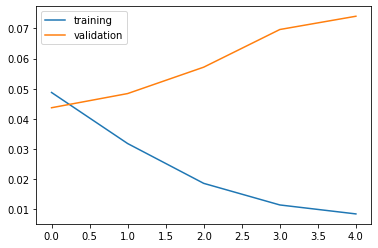

In [37]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [39]:
test_seq = tokenizer.texts_to_sequences(test_data.comment_text)
test_pad = pad_sequences(test_seq, maxlen = maxlen,
                                padding = 'pre',
                                truncating='pre')
predicted = tf.math.sigmoid(cnn.predict(test_pad, batch_size = 200))
predict = np.hstack((test_data.id[:, np.newaxis], predicted))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [42]:
predict

array([['00001cee341fdb12', 0.9999778270721436, 0.1630360335111618, ...,
        4.949542199028656e-05, 0.982805073261261, 0.13253457844257355],
       ['0000247867823ef7', 7.092022542565246e-07, 5.909015854399513e-08,
        ..., 1.9919474598430187e-13, 2.6972952582582366e-07,
        1.447455932890307e-09],
       ['00013b17ad220c46', 0.003256285795941949, 0.0004512714804150164,
        ..., 1.9633218073522585e-07, 0.0004396218282636255,
        0.002103297971189022],
       ...,
       ['fffda9e8d6fafa9e', 1.7178492271341383e-05,
        3.274356458859984e-06, ..., 4.859859181749471e-10,
        1.083209212993097e-06, 4.245605111918849e-08],
       ['fffe8f1340a79fc2', 1.3055284398433287e-05,
        1.3318602896106313e-06, ..., 1.3260584630359062e-08,
        5.994214734528214e-05, 6.47318665869534e-05],
       ['ffffce3fb183ee80', 0.9999979734420776, 5.753433288191445e-05,
        ..., 2.3023765152174747e-06, 0.9682294130325317,
        0.0005399557412602007]], dtype=object)

In [40]:
subm = pd.DataFrame(predict, columns = ['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
subm.to_csv('subm.csv', index = False)

In [41]:
subm

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999978,0.163036,0.99806,4.94954e-05,0.982805,0.132535
1,0000247867823ef7,7.09202e-07,5.90902e-08,1.0807e-05,1.99195e-13,2.6973e-07,1.44746e-09
2,00013b17ad220c46,0.00325629,0.000451271,0.0338559,1.96332e-07,0.000439622,0.0021033
3,00017563c3f7919a,1.65285e-05,6.1897e-07,3.69026e-05,4.31604e-08,2.20687e-05,8.60307e-07
4,00017695ad8997eb,1.0715e-05,1.35395e-05,0.000688151,3.12993e-07,0.000309353,4.82865e-08
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.574055,1.638e-05,0.359278,2.31772e-09,0.0169476,2.81076e-05
153160,fffd7a9a6eb32c16,9.13758e-06,4.55759e-08,2.07551e-05,1.49168e-06,1.28268e-05,5.13722e-07
153161,fffda9e8d6fafa9e,1.71785e-05,3.27436e-06,2.57775e-05,4.85986e-10,1.08321e-06,4.24561e-08
153162,fffe8f1340a79fc2,1.30553e-05,1.33186e-06,0.000221159,1.32606e-08,5.99421e-05,6.47319e-05
